In [11]:
import pandas as pd

# Carrega o CSV
metadata = pd.read_csv("C:/Users/luisp/OneDrive/Mestrado/1ano/2sem/Deep Learning (DL)/Project/rare_species 1/metadata.csv")

# Visualiza o que está lá
metadata.head()

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...


In [12]:
import os
import pandas as pd

# Caminho base onde estão as pastas com imagens
base_image_dir = 'C:/Users/luisp/OneDrive/Mestrado/1ano/2sem/Deep Learning (DL)/Project/rare_species 1'

# Criar coluna com caminho absoluto para cada imagem
metadata['absolute_path'] = metadata['file_path'].apply(lambda x: os.path.join(base_image_dir, x))

# Verificar se o ficheiro existe no disco
metadata['exists_on_disk'] = metadata['absolute_path'].apply(os.path.exists)

# Mostrar quantos existem e quantos faltam
total_in_metadata = len(metadata)
existing_on_disk = metadata['exists_on_disk'].sum()
real_images_on_disk = sum(len(files) for _, _, files in os.walk(base_image_dir))

print(f"Total de imagens no metadata: {total_in_metadata}")
print(f"Total de imagens que existem no disco: {existing_on_disk}")
print(f"Total real de ficheiros de imagem no disco: {real_images_on_disk}")

# Mostrar exemplos de imagens em falta
print("\nExemplos de imagens em falta:")
print(metadata[~metadata['exists_on_disk']][['file_path']].head())

# Remover entradas com ficheiros em falta
metadata_clean = metadata[metadata['exists_on_disk']].drop(columns=['exists_on_disk'])

# Guardar novo ficheiro limpo
metadata_clean.to_csv("C:/Users/luisp/OneDrive/Mestrado/1ano/2sem/Deep Learning (DL)/Project/rare_species 1/metadata_clean.csv", index=False)

print("\n✅ metadata_clean.csv guardado com sucesso — apenas com imagens existentes.")

Total de imagens no metadata: 11983
Total de imagens que existem no disco: 11946
Total real de ficheiros de imagem no disco: 11948

Exemplos de imagens em falta:
                                              file_path
65    chordata_percidae/2702997_211786_eol-full-size...
1662  chordata_laridae/30123070_45516169_eol-full-si...
1675  arthropoda_carabidae/28933425_2867406_eol-full...
2062  arthropoda_carabidae/27782880_2867406_eol-full...
2109  chordata_callitrichidae/29473109_323892_eol-fu...

✅ metadata_clean.csv guardado com sucesso — apenas com imagens existentes.


In [13]:
from sklearn.preprocessing import LabelEncoder

# Codificar a coluna 'family'
label_encoder = LabelEncoder()
metadata_clean['label_encoded'] = label_encoder.fit_transform(metadata_clean['family'])

# Guarda a lista de labels para decodificar mais tarde se precisares
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Visualiza
metadata_clean[['family', 'label_encoded']].drop_duplicates()

,family,label_encoded
0,unionidae,193
1,geoemydidae,84
2,cryptobranchidae,56
3,turdidae,192
4,indriidae,100
...,...,...
1421,cyprinodontidae,59
1450,cacatuidae,28
1536,balaenidae,19
1600,alligatoridae,7


In [14]:
from sklearn.model_selection import train_test_split

# Split inicial: treino (70%) e resto (30%)
train_df, temp_df = train_test_split(metadata_clean, test_size=0.3, stratify=metadata_clean['label_encoded'], random_state=42)

# Segundo split: validação (15%) e teste (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label_encoded'], random_state=42)

# Verifica o tamanho de cada split
print(f"Treino: {len(train_df)} | Validação: {len(val_df)} | Teste: {len(test_df)}")

Treino: 8362 | Validação: 1792 | Teste: 1792


In [15]:
# Fase 1 - Passo 4 - Opcional
import os

# Cria a coluna com caminho absoluto
for df in [train_df, val_df, test_df]:
    df['absolute_path'] = df['file_path'].apply(lambda x: os.path.normpath(os.path.join(base_image_dir, x)))

In [16]:
# Fase 2 - Passo 1
import tensorflow as tf

# Parâmetros principais
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [17]:
# Fase 2 - Passo 3
# Função para carregar e processar uma imagem
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normaliza para [0, 1]
    return image, label

# Data augmentation (apenas para treino)
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

In [18]:
# Fase 2 - Passo 4
def prepare_dataset(df, augment_data=False, shuffle=False):
    paths = df['absolute_path'].values
    labels = df['label_encoded'].values

    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(load_image, num_parallel_calls=AUTOTUNE)

    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

# Criar os 3 datasets
train_dataset = prepare_dataset(train_df, augment_data=True, shuffle=True)
val_dataset = prepare_dataset(val_df)
test_dataset = prepare_dataset(test_df)



🔧 Treinando modelo: EfficientNetB0
Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 115s 406ms/step - accuracy: 0.0202 - loss: 5.1667 - val_accuracy: 0.0246 - val_loss: 5.0583
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 97s 362ms/step - accuracy: 0.0277 - loss: 5.0965 - val_accuracy: 0.0251 - val_loss: 5.0542
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 107s 396ms/step - accuracy: 0.0214 - loss: 5.0970 - val_accuracy: 0.0223 - val_loss: 5.0583
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 111s 411ms/step - accuracy: 0.0260 - loss: 5.0954 - val_accuracy: 0.0246 - val_loss: 5.0526
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 113s 420ms/step - accuracy: 0.0214 - loss: 5.1077 - val_accuracy: 0.0229 - val_loss: 5.0549
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 121s 446ms/step - accuracy: 0.0236 - loss: 5.1053 - val_accuracy: 0.0223 - val_loss: 5.0553
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 116s 428ms/step - accuracy: 0.0230 - loss: 5.0885 - val_accuracy: 0.0223 - val_loss: 5.0589
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 1

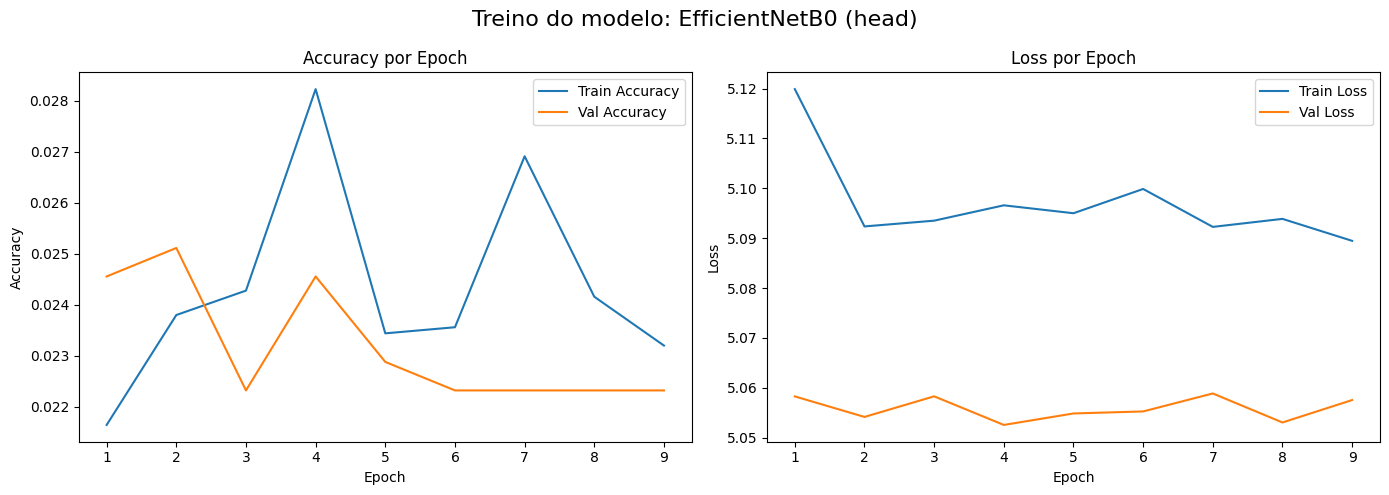

Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 118s 416ms/step - accuracy: 0.0169 - loss: 5.2370 - val_accuracy: 0.0229 - val_loss: 5.0790
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 118s 440ms/step - accuracy: 0.0227 - loss: 5.0966 - val_accuracy: 0.0251 - val_loss: 5.0462
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 113s 423ms/step - accuracy: 0.0230 - loss: 5.0597 - val_accuracy: 0.0251 - val_loss: 5.0398
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 114s 425ms/step - accuracy: 0.0225 - loss: 5.0591 - val_accuracy: 0.0251 - val_loss: 5.0363
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 115s 428ms/step - accuracy: 0.0276 - loss: 5.0513 - val_accuracy: 0.0257 - val_loss: 5.0330
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 115s 427ms/step - accuracy: 0.0235 - loss: 5.0461 - val_accuracy: 0.0257 - val_loss: 5.0301
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 113s 420ms/step - accuracy: 0.0239 - loss: 5.0477 - val_accuracy: 0.0251 - val_loss: 5.0295
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 113s 419ms/step - accuracy: 0.0255 -

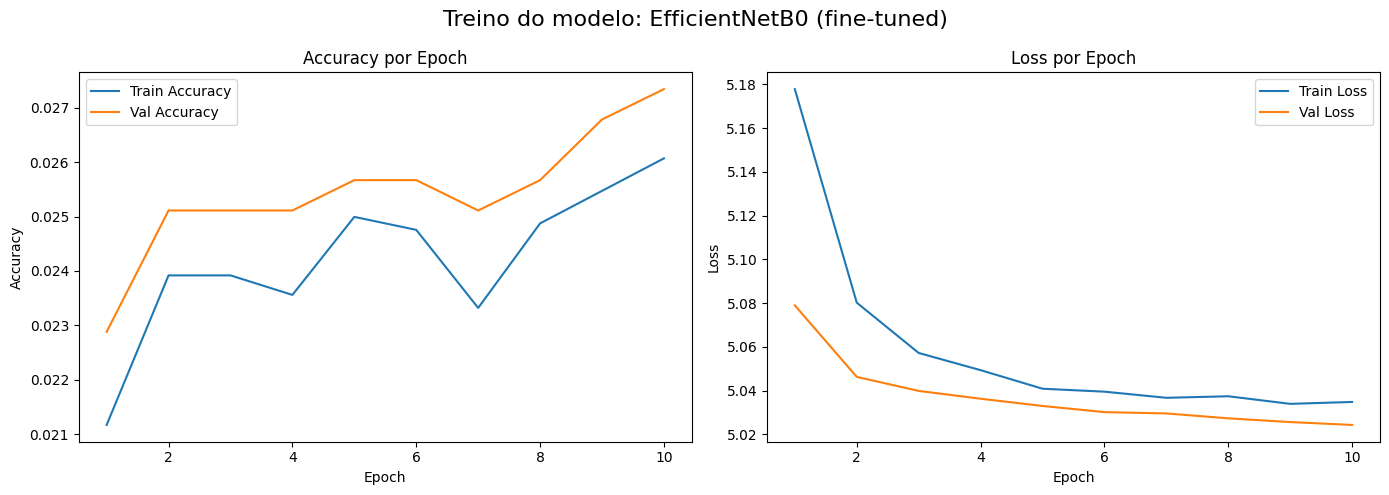

56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.0246 - loss: 5.0438

🔧 Treinando modelo: EfficientNetB3
Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.0220 - loss: 5.1607 - val_accuracy: 0.0379 - val_loss: 5.0393
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - accuracy: 0.0299 - loss: 5.0735 - val_accuracy: 0.0268 - val_loss: 5.0222
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - accuracy: 0.0298 - loss: 5.0648 - val_accuracy: 0.0391 - val_loss: 4.9965
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.0323 - loss: 5.0366 - val_accuracy: 0.0424 - val_loss: 4.9960
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.0328 - loss: 5.0436 - val_accuracy: 0.0402 - val_loss: 4.9947
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.0335 - loss: 5.0339 - val_accuracy: 0.0223 - val_loss: 4.9870
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.0331 - loss: 5.0261 - val_accuracy: 0.0257 - va

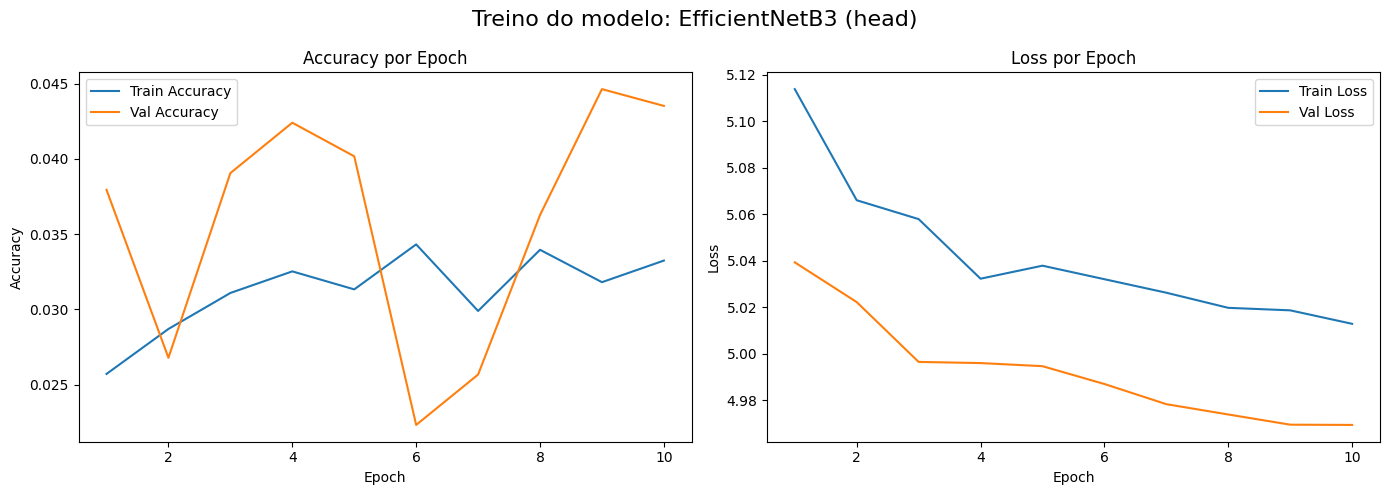

Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - accuracy: 0.0255 - loss: 5.1464 - val_accuracy: 0.0340 - val_loss: 5.0396
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.0375 - loss: 4.9790 - val_accuracy: 0.0419 - val_loss: 4.9456
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.0394 - loss: 4.9580 - val_accuracy: 0.0435 - val_loss: 4.9313
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.0397 - loss: 4.9546 - val_accuracy: 0.0435 - val_loss: 4.9276
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.0423 - loss: 4.9339 - val_accuracy: 0.0413 - val_loss: 4.9255
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.0421 - loss: 4.9273 - val_accuracy: 0.0430 - val_loss: 4.9210
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.0406 - loss: 4.9160 - val_accuracy: 0.0424 - val_loss: 4.9193
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.0409 - loss: 4.9041 - val_accu

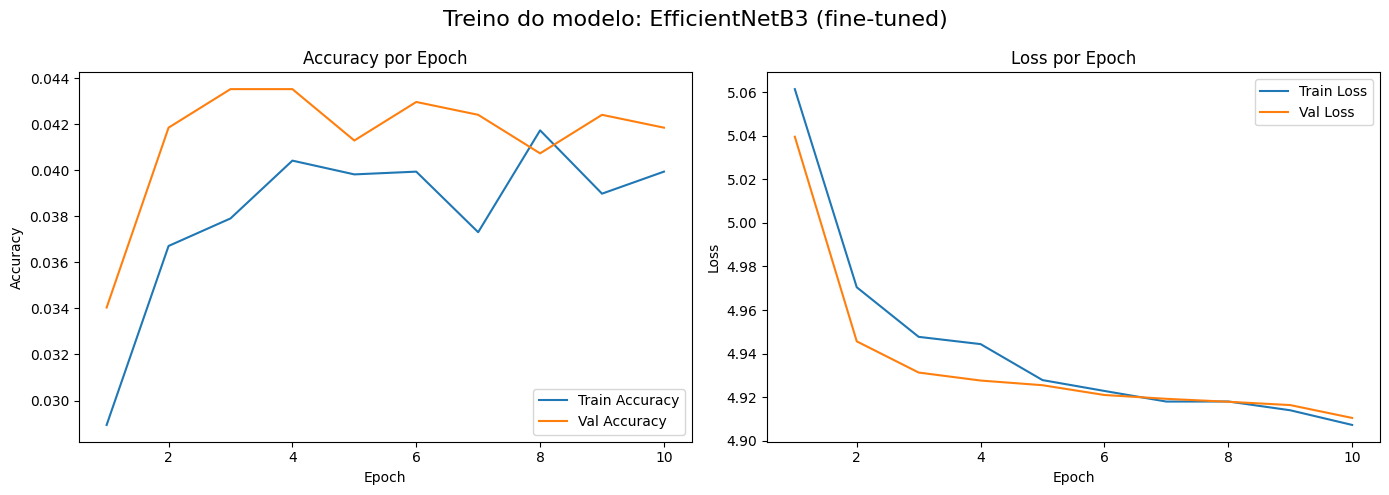

56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.0316 - loss: 4.9191

🔧 Treinando modelo: ResNet50
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 32s 0us/step
Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 214s 795ms/step - accuracy: 0.0203 - loss: 5.4013 - val_accuracy: 0.0435 - val_loss: 4.9838
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 224s 844ms/step - accuracy: 0.0339 - loss: 5.0946 - val_accuracy: 0.0396 - val_loss: 4.9362
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 224s 846ms/step - accuracy: 0.0381 - loss: 5.0262 - val_accuracy: 0.0480 - val_loss: 4.9125
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 223s 839ms/step - accuracy: 0.0428 - loss: 4.9708 - val_accuracy: 0.0480 - val_loss: 4.8880
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 222s 837ms/step - accuracy: 0.0463 - loss: 4.9154 - val_accuracy: 0.0536 - val_loss: 4.8630
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 219s 825ms/step - accuracy: 0.0489 - loss: 4.8938 - val_accuracy: 0.0402 - val_loss: 4.8477
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 222s 838ms/st

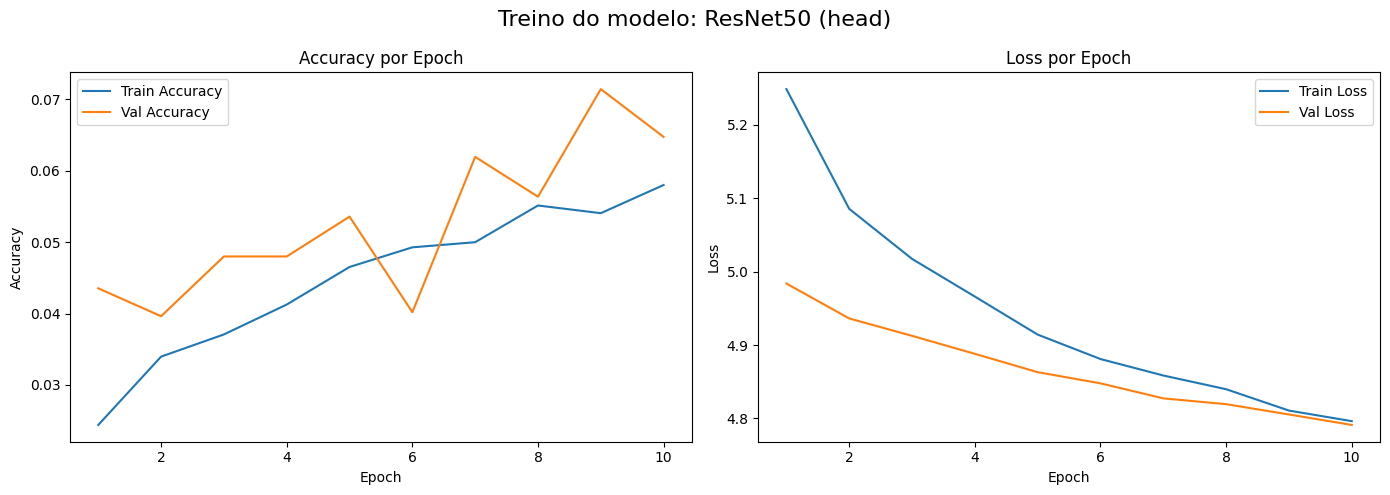

Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 261s 966ms/step - accuracy: 0.0467 - loss: 6.9109 - val_accuracy: 0.0413 - val_loss: 5.0859
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 253s 955ms/step - accuracy: 0.0959 - loss: 4.5519 - val_accuracy: 0.1094 - val_loss: 4.5615
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 256s 966ms/step - accuracy: 0.1209 - loss: 4.3888 - val_accuracy: 0.1183 - val_loss: 4.4661
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 255s 963ms/step - accuracy: 0.1364 - loss: 4.2374 - val_accuracy: 0.1328 - val_loss: 4.3959
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 258s 973ms/step - accuracy: 0.1477 - loss: 4.1151 - val_accuracy: 0.1356 - val_loss: 4.3760
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 254s 959ms/step - accuracy: 0.1661 - loss: 4.0087 - val_accuracy: 0.1440 - val_loss: 4.3130
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 258s 974ms/step - accuracy: 0.1701 - loss: 3.9445 - val_accuracy: 0.1546 - val_loss: 4.2656
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 253s 955ms/step - accuracy: 0.1923 -

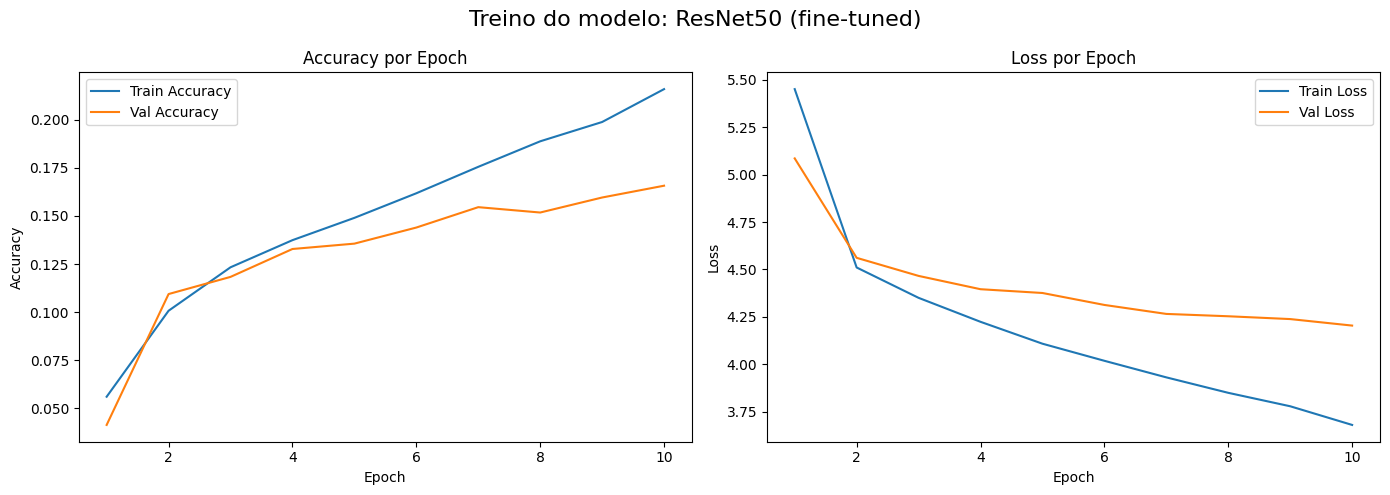

56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 624ms/step - accuracy: 0.1613 - loss: 4.1390

🔧 Treinando modelo: DenseNet121
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 21s 1us/step
Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 230s 837ms/step - accuracy: 0.0651 - loss: 5.1850 - val_accuracy: 0.2734 - val_loss: 3.3657
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 211s 796ms/step - accuracy: 0.3095 - loss: 3.1454 - val_accuracy: 0.4085 - val_loss: 2.6007
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 213s 806ms/step - accuracy: 0.4425 - loss: 2.3876 - val_accuracy: 0.4922 - val_loss: 2.2275
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 212s 802ms/step - accuracy: 0.5264 - loss: 1.9606 - val_accuracy: 0.5296 - val_loss: 2.0300
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 213s 803ms/step - accuracy: 0.5754 - loss: 1.7244 - val_accuracy: 0.5502 - val_loss: 1.8931
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 213s 803ms/step - accuracy: 0.6271 - loss: 1.5255 - val_accuracy: 0.5820 - val_loss: 1.7991
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 212s 80

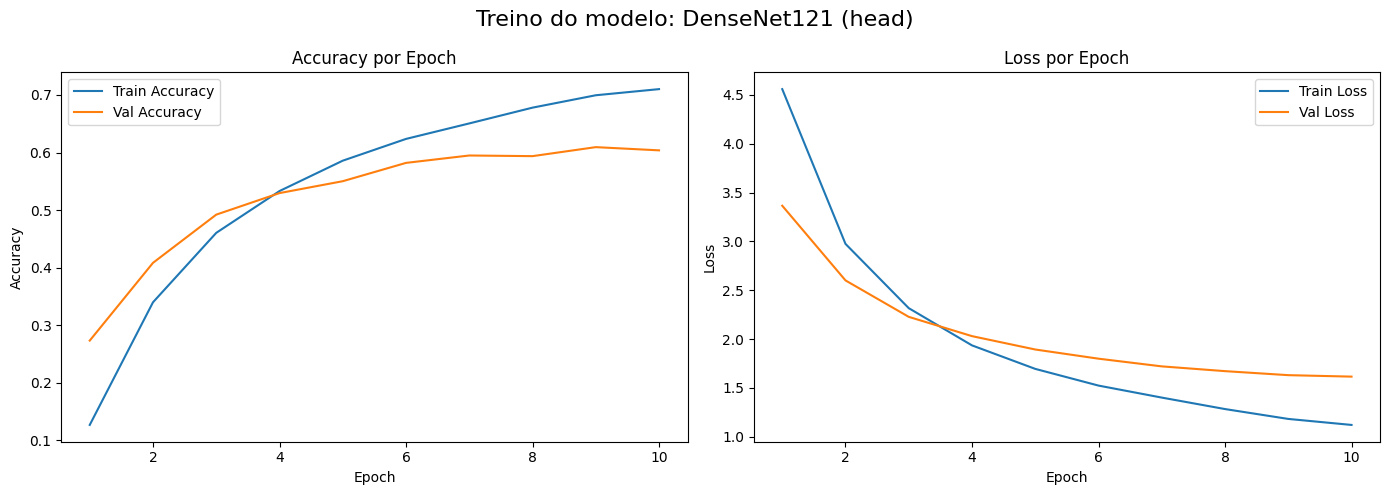

Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 238s 869ms/step - accuracy: 0.6748 - loss: 1.2283 - val_accuracy: 0.5904 - val_loss: 1.6489
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 220s 832ms/step - accuracy: 0.6980 - loss: 1.1621 - val_accuracy: 0.6004 - val_loss: 1.6232
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 226s 854ms/step - accuracy: 0.7085 - loss: 1.1239 - val_accuracy: 0.6071 - val_loss: 1.5980
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 223s 842ms/step - accuracy: 0.7259 - loss: 1.0826 - val_accuracy: 0.6088 - val_loss: 1.5823
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 227s 857ms/step - accuracy: 0.7317 - loss: 1.0639 - val_accuracy: 0.6116 - val_loss: 1.5719
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 227s 859ms/step - accuracy: 0.7209 - loss: 1.0710 - val_accuracy: 0.6138 - val_loss: 1.5627
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 230s 870ms/step - accuracy: 0.7252 - loss: 1.0530 - val_accuracy: 0.6166 - val_loss: 1.5551
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 238s 898ms/step - accuracy: 0.7438 -

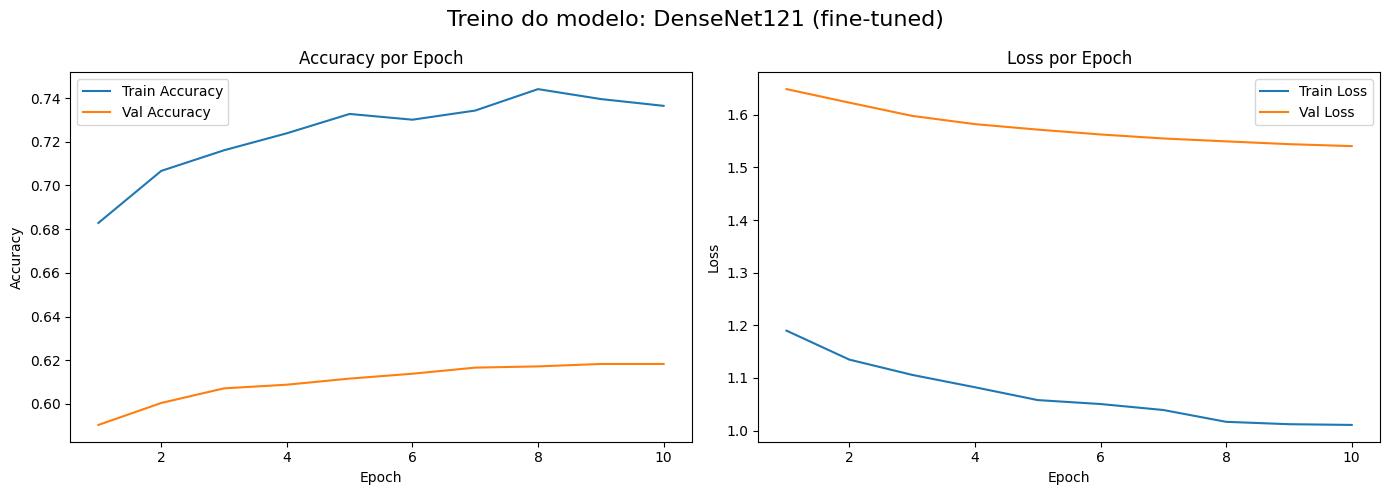

56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 701ms/step - accuracy: 0.6213 - loss: 1.4824

🔧 Treinando modelo: MobileNetV2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 17s 2us/step
Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 78s 282ms/step - accuracy: 0.1221 - loss: 4.6893 - val_accuracy: 0.3984 - val_loss: 2.6617
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 74s 274ms/step - accuracy: 0.4828 - loss: 2.1740 - val_accuracy: 0.4922 - val_loss: 2.1367
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 74s 273ms/step - accuracy: 0.6088 - loss: 1.5645 - val_accuracy: 0.5352 - val_loss: 1.9582
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 74s 274ms/step - accuracy: 0.6822 - loss: 1.2488 - val_accuracy: 0.5631 - val_loss: 1.8381
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 74s 274ms/step - accuracy: 0.7280 - loss: 1.0613 - val_accuracy: 0.5731 - val_loss: 1.7774
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 75s 277ms/step - accuracy: 0.7780 - loss: 0.8812 - val_accuracy: 0.5876 - val_loss: 1.7375
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 74s 275ms/step 

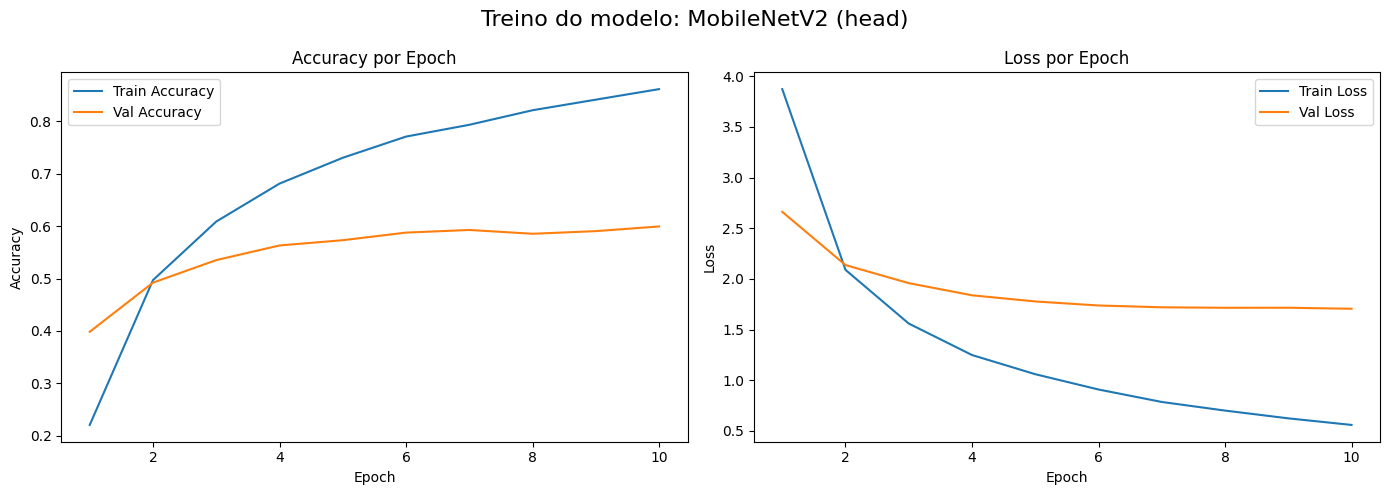

Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 96s 334ms/step - accuracy: 0.7372 - loss: 0.9679 - val_accuracy: 0.6055 - val_loss: 1.6719
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 85s 314ms/step - accuracy: 0.8078 - loss: 0.7634 - val_accuracy: 0.6055 - val_loss: 1.6580
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 86s 318ms/step - accuracy: 0.8308 - loss: 0.6973 - val_accuracy: 0.6060 - val_loss: 1.6528
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 86s 317ms/step - accuracy: 0.8421 - loss: 0.6398 - val_accuracy: 0.6094 - val_loss: 1.6466
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 86s 317ms/step - accuracy: 0.8593 - loss: 0.5862 - val_accuracy: 0.6110 - val_loss: 1.6416
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 86s 317ms/step - accuracy: 0.8771 - loss: 0.5413 - val_accuracy: 0.6122 - val_loss: 1.6368
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 86s 318ms/step - accuracy: 0.8800 - loss: 0.5040 - val_accuracy: 0.6127 - val_loss: 1.6365
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 86s 317ms/step - accuracy: 0.8852 - loss: 0

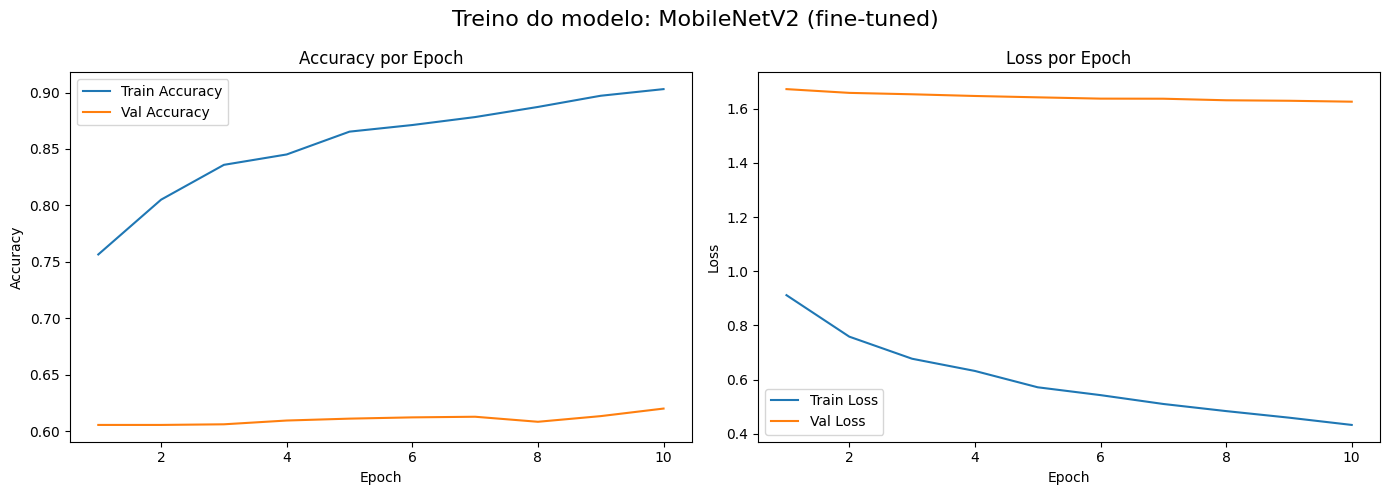

56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step - accuracy: 0.6314 - loss: 1.4839

🔧 Treinando modelo: InceptionV3
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 92s 1us/step
Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 246s 908ms/step - accuracy: 0.1787 - loss: 4.4455 - val_accuracy: 0.4671 - val_loss: 2.4854
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 220s 832ms/step - accuracy: 0.5343 - loss: 2.0600 - val_accuracy: 0.5681 - val_loss: 1.8843
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 219s 827ms/step - accuracy: 0.6437 - loss: 1.4719 - val_accuracy: 0.6071 - val_loss: 1.6787
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 221s 832ms/step - accuracy: 0.7027 - loss: 1.1914 - val_accuracy: 0.6189 - val_loss: 1.5818
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 221s 836ms/step - accuracy: 0.7492 - loss: 1.0027 - val_accuracy: 0.6390 - val_loss: 1.5040
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 220s 830ms/step - accuracy: 0.7846 - loss: 0.8701 - val_accuracy: 0.6512 - val_loss: 1.4594
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 218s 82

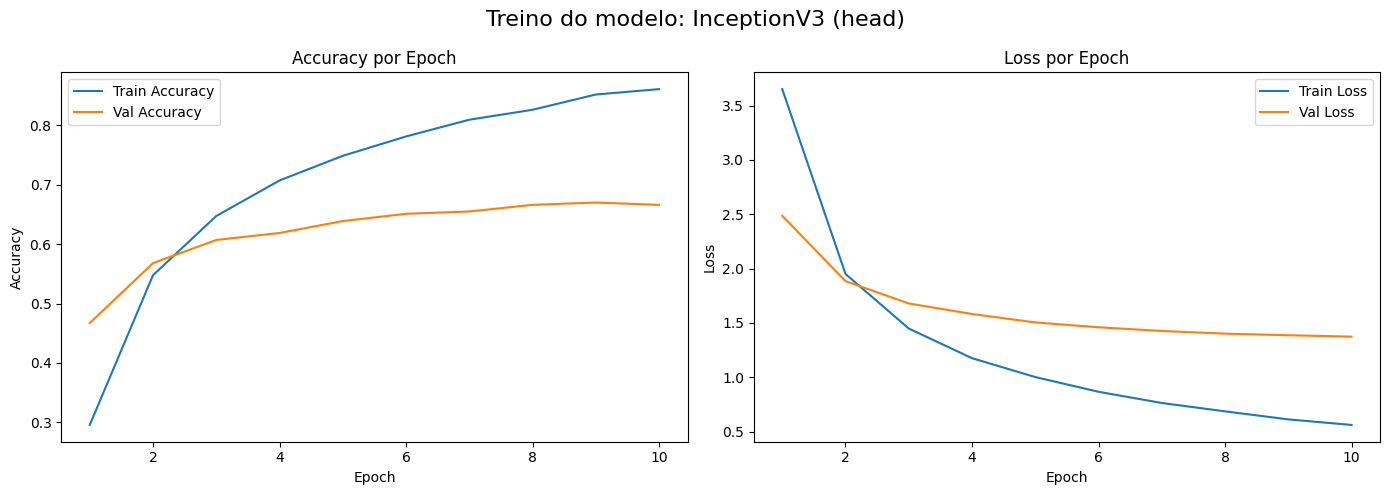

Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 244s 901ms/step - accuracy: 0.8780 - loss: 0.5447 - val_accuracy: 0.6808 - val_loss: 1.3345
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 233s 877ms/step - accuracy: 0.9014 - loss: 0.4939 - val_accuracy: 0.6836 - val_loss: 1.3207
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 231s 872ms/step - accuracy: 0.8996 - loss: 0.4787 - val_accuracy: 0.6853 - val_loss: 1.3126
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 231s 872ms/step - accuracy: 0.9086 - loss: 0.4644 - val_accuracy: 0.6842 - val_loss: 1.3049
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 230s 870ms/step - accuracy: 0.9083 - loss: 0.4545 - val_accuracy: 0.6853 - val_loss: 1.3000
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 231s 872ms/step - accuracy: 0.9181 - loss: 0.4350 - val_accuracy: 0.6858 - val_loss: 1.2947
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 232s 878ms/step - accuracy: 0.9201 - loss: 0.4262 - val_accuracy: 0.6853 - val_loss: 1.2903
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 233s 879ms/step - accuracy: 0.9127 -

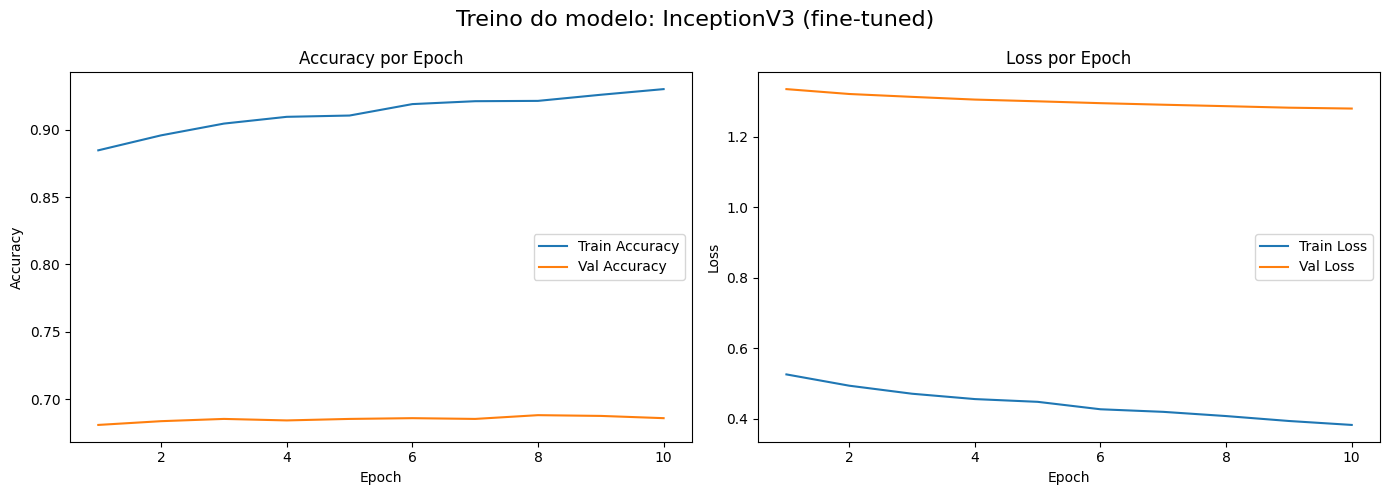

56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 722ms/step - accuracy: 0.6892 - loss: 1.1859

🔧 Treinando modelo: NASNetMobile
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 14s 1us/step
Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 106s 357ms/step - accuracy: 0.1422 - loss: 4.4983 - val_accuracy: 0.4085 - val_loss: 2.6262
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 91s 339ms/step - accuracy: 0.4539 - loss: 2.3135 - val_accuracy: 0.4905 - val_loss: 2.1313
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 89s 332ms/step - accuracy: 0.5433 - loss: 1.8097 - val_accuracy: 0.5206 - val_loss: 1.9567
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 92s 343ms/step - accuracy: 0.5992 - loss: 1.5503 - val_accuracy: 0.5458 - val_loss: 1.8632
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 91s 337ms/step - accuracy: 0.6313 - loss: 1.3854 - val_accuracy: 0.5480 - val_loss: 1.7991
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 91s 338ms/step - accuracy: 0.6658 - loss: 1.2496 - val_accuracy: 0.5580 - val_loss: 1.7574
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 90s 335ms/s

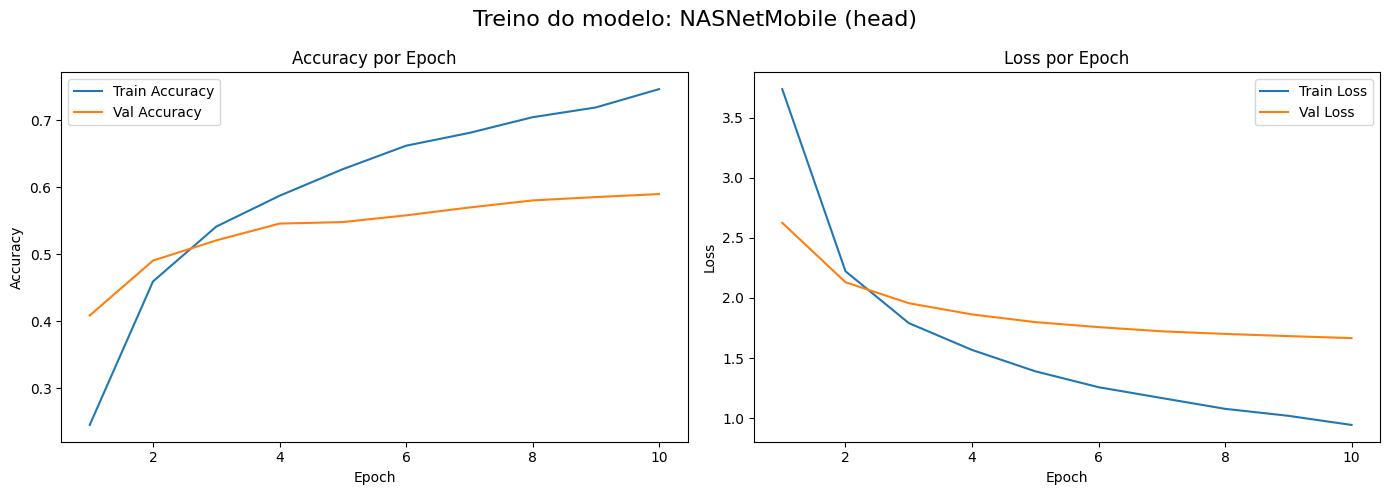

Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 122s 408ms/step - accuracy: 0.7707 - loss: 0.9056 - val_accuracy: 0.5949 - val_loss: 1.6565
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 93s 346ms/step - accuracy: 0.7748 - loss: 0.8592 - val_accuracy: 0.5949 - val_loss: 1.6504
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 90s 334ms/step - accuracy: 0.7823 - loss: 0.8456 - val_accuracy: 0.5954 - val_loss: 1.6462
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 94s 348ms/step - accuracy: 0.7709 - loss: 0.8633 - val_accuracy: 0.5965 - val_loss: 1.6429
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 92s 342ms/step - accuracy: 0.7830 - loss: 0.8314 - val_accuracy: 0.5988 - val_loss: 1.6405
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 96s 355ms/step - accuracy: 0.7852 - loss: 0.8286 - val_accuracy: 0.5988 - val_loss: 1.6384
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 93s 344ms/step - accuracy: 0.7810 - loss: 0.8357 - val_accuracy: 0.6004 - val_loss: 1.6366
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 96s 357ms/step - accuracy: 0.7826 - loss: 

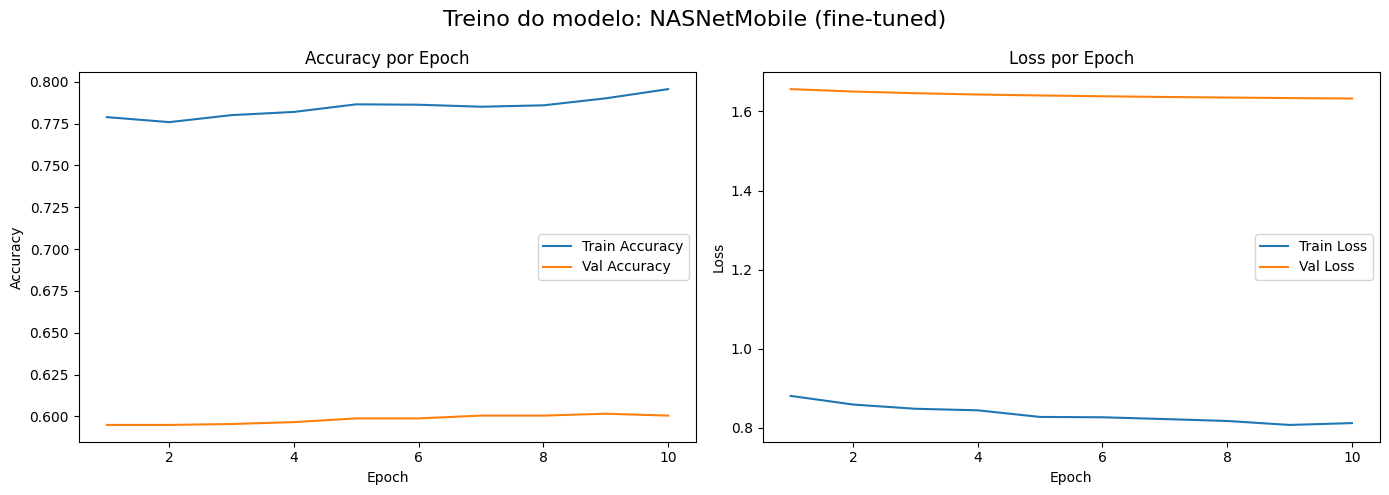

56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 271ms/step - accuracy: 0.5969 - loss: 1.5716

🔧 Treinando modelo: ConvNeXtTiny

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 82s 1us/step
Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 935s 4s/step - accuracy: 0.0196 - loss: 5.6208 - val_accuracy: 0.0575 - val_loss: 4.9441
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 935s 4s/step - accuracy: 0.0449 - loss: 5.0234 - val_accuracy: 0.0686 - val_loss: 4.8637
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 942s 4s/step - accuracy: 0.0565 - loss: 4.9014 - val_accuracy: 0.0731 - val_loss: 4.7896
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 931s 4s/step - accuracy: 0.0784 - loss: 4.8018 - val_accuracy: 0.0859 - val_loss: 4.7253
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 931s 4s/step - accuracy: 0.0876 - loss: 4.6988 - val_accuracy: 0.0932 - val_loss: 4.6752
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 939s 4s/step - accuracy: 0.0961 - loss: 4.6414 - val_accuracy: 0.1138 - val_loss: 4.6217
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 951s 4s/step - accura

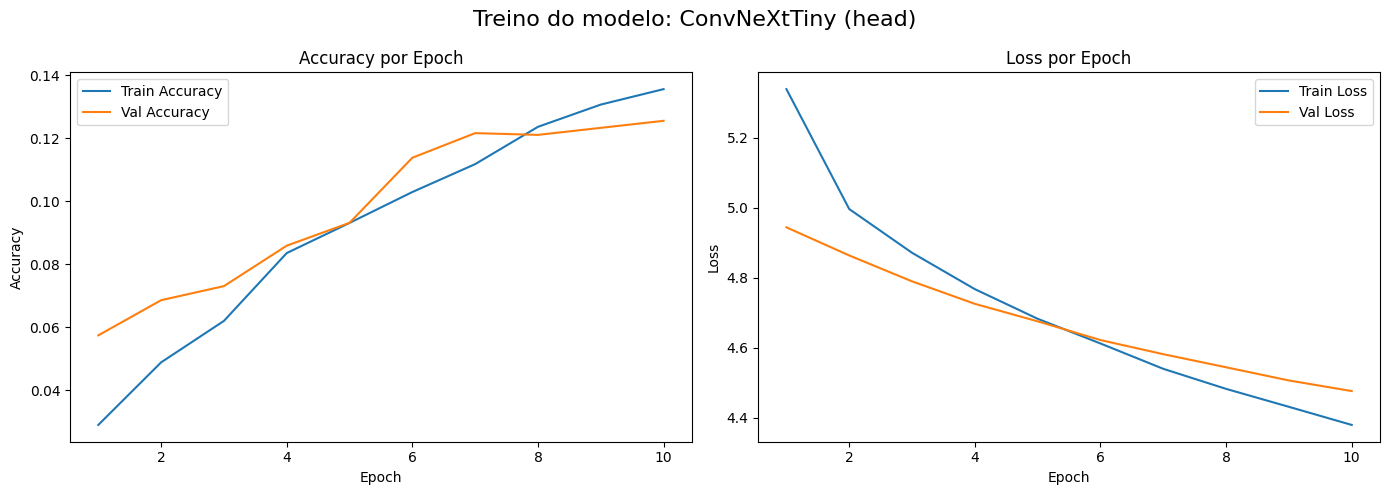

Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 1466s 5s/step - accuracy: 0.1530 - loss: 4.2705 - val_accuracy: 0.1535 - val_loss: 4.2796
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 1394s 5s/step - accuracy: 0.1788 - loss: 4.0571 - val_accuracy: 0.1585 - val_loss: 4.1813
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 1407s 5s/step - accuracy: 0.1904 - loss: 3.9324 - val_accuracy: 0.1629 - val_loss: 4.1104
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 1401s 5s/step - accuracy: 0.2027 - loss: 3.8234 - val_accuracy: 0.1741 - val_loss: 4.0399
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 1393s 5s/step - accuracy: 0.2221 - loss: 3.7397 - val_accuracy: 0.1853 - val_loss: 3.9841
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 1408s 5s/step - accuracy: 0.2280 - loss: 3.6630 - val_accuracy: 0.1925 - val_loss: 3.9363
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 1400s 5s/step - accuracy: 0.2523 - loss: 3.5565 - val_accuracy: 0.1970 - val_loss: 3.8973
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 1397s 5s/step - accuracy: 0.2510 - loss: 3.4875 - 

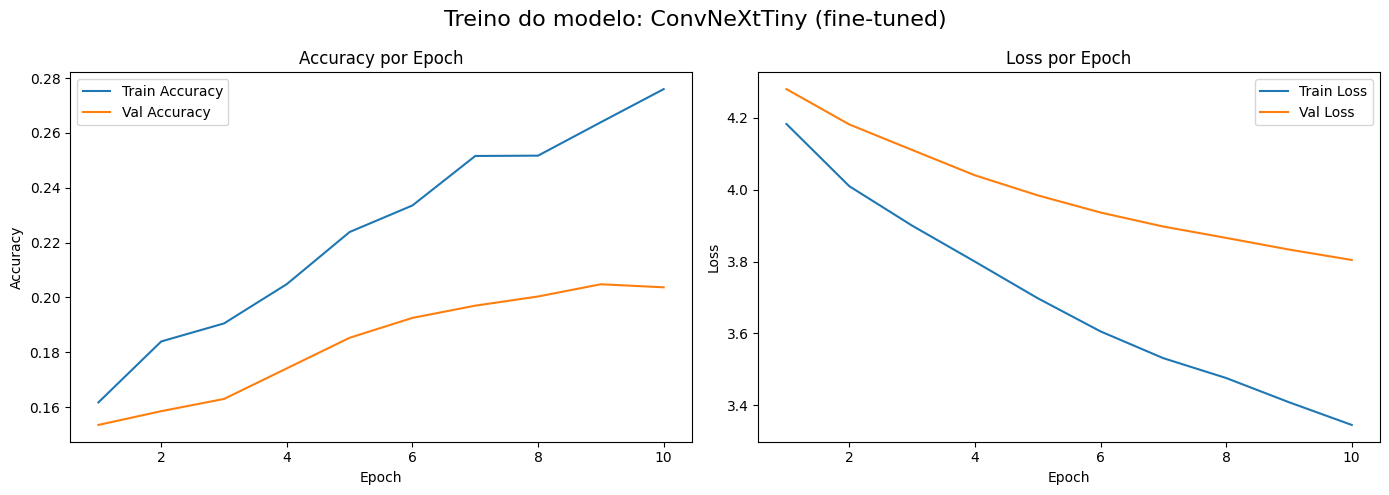

56/56 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.2103 - loss: 3.7332

🔧 Treinando modelo: VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 146s 2us/step
Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.0222 - loss: 5.2547 - val_accuracy: 0.0647 - val_loss: 4.8606
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 0.0633 - loss: 4.8346 - val_accuracy: 0.0876 - val_loss: 4.7048
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 0.0915 - loss: 4.6700 - val_accuracy: 0.1222 - val_loss: 4.5727
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 0.1166 - loss: 4.5116 - val_accuracy: 0.1311 - val_loss: 4.4630
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 0.1316 - loss: 4.3838 - val_accuracy: 0.1417 - val_loss: 4.3673
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 435s 2s/step - accuracy: 0.1410 - loss: 4.2860 - val_accuracy: 0.1523 - val_loss: 4.2854
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 435s 2s/step - accuracy: 0.1517 

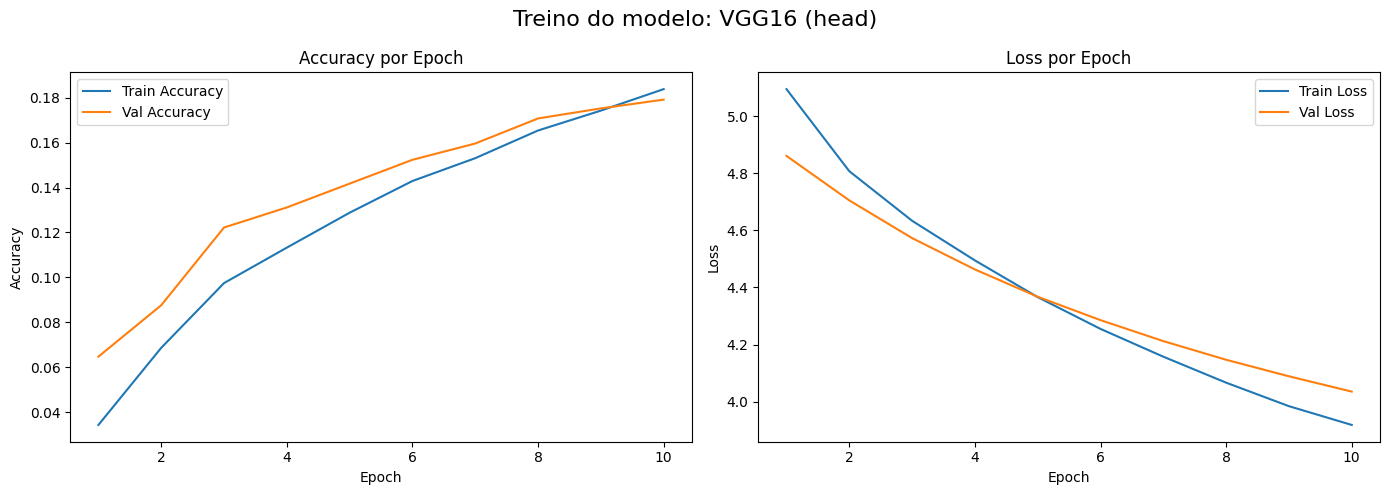

Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 1186s 4s/step - accuracy: 0.2584 - loss: 3.2953 - val_accuracy: 0.2846 - val_loss: 3.2379
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 1204s 5s/step - accuracy: 0.3473 - loss: 2.7725 - val_accuracy: 0.3192 - val_loss: 3.1210
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 1183s 5s/step - accuracy: 0.3947 - loss: 2.5376 - val_accuracy: 0.3376 - val_loss: 2.9769
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 1180s 4s/step - accuracy: 0.4220 - loss: 2.3823 - val_accuracy: 0.3566 - val_loss: 2.9803
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 1181s 4s/step - accuracy: 0.4509 - loss: 2.2408 - val_accuracy: 0.3689 - val_loss: 2.9118
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 1181s 4s/step - accuracy: 0.4841 - loss: 2.1044 - val_accuracy: 0.3862 - val_loss: 2.9272
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 1186s 5s/step - accuracy: 0.5039 - loss: 1.9479 - val_accuracy: 0.3940 - val_loss: 2.7511
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 1182s 5s/step - accuracy: 0.5364 - loss: 1.8332 - 

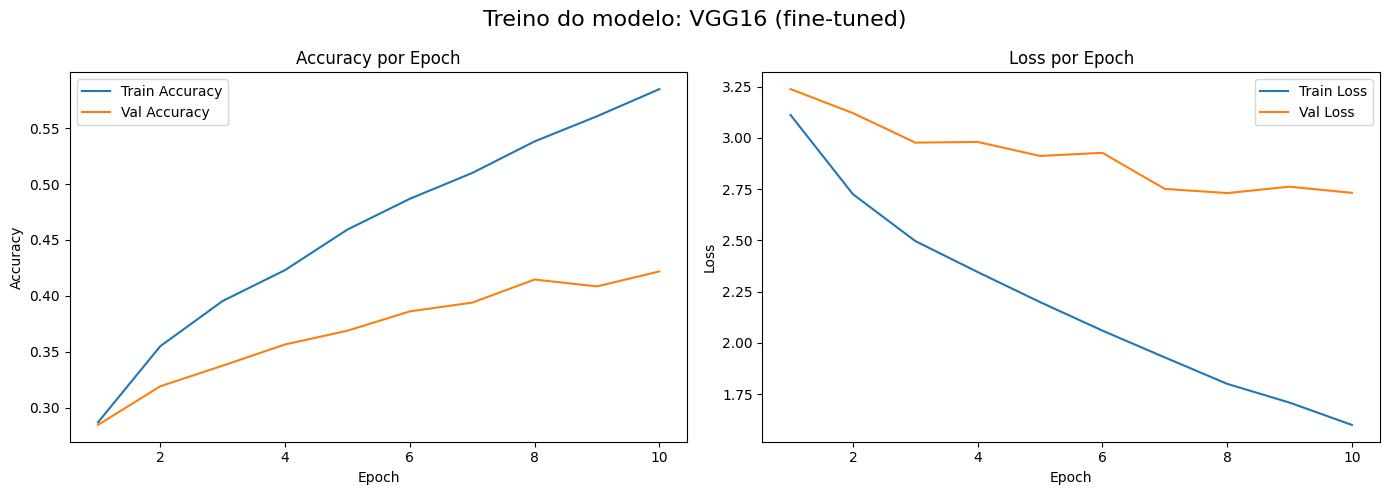

56/56 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.4107 - loss: 2.6686
            model      loss  accuracy  time_minutes
5     InceptionV3  1.181167  0.699777         78.12
3     DenseNet121  1.455526  0.641183         75.06
4     MobileNetV2  1.498691  0.633929         27.43
6    NASNetMobile  1.551375  0.610491         32.06
8           VGG16  2.664622  0.421875        273.79
7    ConvNeXtTiny  3.759692  0.202567        394.98
2        ResNet50  4.128206  0.164062         79.69
1  EfficientNetB3  4.897031  0.035714        127.40
0  EfficientNetB0  5.022737  0.025112         36.12


In [19]:
import tensorflow as tf
from tensorflow.keras.applications import (
    EfficientNetB0, EfficientNetB3, ResNet50, DenseNet121,
    MobileNetV2, InceptionV3, NASNetMobile, VGG16, ConvNeXtTiny
)
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
import time

# --- CONFIGURACAO ---
NUM_CLASSES = 202  # Ajusta ao teu dataset
EPOCHS_HEAD = 10
EPOCHS_FINE = 10

models_to_test = [
    {"name": "EfficientNetB0", "fn": EfficientNetB0, "input_size": (224, 224)},
    {"name": "EfficientNetB3", "fn": EfficientNetB3, "input_size": (300, 300)},
    {"name": "ResNet50", "fn": ResNet50, "input_size": (224, 224)},
    {"name": "DenseNet121", "fn": DenseNet121, "input_size": (224, 224)},
    {"name": "MobileNetV2", "fn": MobileNetV2, "input_size": (224, 224)},
    {"name": "InceptionV3", "fn": InceptionV3, "input_size": (299, 299)},
    {"name": "NASNetMobile", "fn": NASNetMobile, "input_size": (224, 224)},
    {"name": "ConvNeXtTiny", "fn": ConvNeXtTiny, "input_size": (224, 224)},
    {"name": "VGG16", "fn": VGG16, "input_size": (224, 224)}
]

# --- FUNCOES ---
def build_model(model_fn, input_shape, num_classes, dropout_rate=0.3):
    base_model = model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model, base_model

def fine_tune_model(model, base_model, fine_tune_at=20, lr=1e-5):
    base_model.trainable = True
    for layer in base_model.layers[:-fine_tune_at]:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def plot_training(history, model_name):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.suptitle(f"Treino do modelo: {model_name}", fontsize=16)

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title('Accuracy por Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title('Loss por Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- LOOP DE TREINO ---
results = []

for model_info in models_to_test:
    print(f"\n🔧 Treinando modelo: {model_info['name']}")
    start_time = time.time()

    IMG_SIZE = model_info["input_size"]
    train_dataset = prepare_dataset(train_df, augment_data=True, shuffle=True)
    val_dataset = prepare_dataset(val_df)
    test_dataset = prepare_dataset(test_df)

    model, base_model = build_model(model_info["fn"], IMG_SIZE + (3,), NUM_CLASSES)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(f"best_{model_info['name']}.keras", save_best_only=True)
    ]

    history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS_HEAD, callbacks=callbacks)
    plot_training(history, model_info["name"] + " (head)")

    model = fine_tune_model(model, base_model, fine_tune_at=20)
    history_ft = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS_FINE, callbacks=callbacks)
    plot_training(history_ft, model_info["name"] + " (fine-tuned)")

    result = model.evaluate(test_dataset, return_dict=True)
    result['model'] = model_info["name"]
    result['time_minutes'] = round((time.time() - start_time) / 60, 2)
    results.append(result)

# --- RESULTADOS FINAIS ---
df_results = pd.DataFrame(results)
df_results = df_results[['model', 'loss', 'accuracy', 'time_minutes']]
print(df_results.sort_values('accuracy', ascending=False))